# Introduction

In this project, deep learning will be used to predict forest cover type based only on cartographic variables. The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. The cover types are the following:

- Spruce/Fir
- Lodgepole Pine
- Ponderosa Pine
- Cottonwood/Willow
- Aspen
- Douglas-fir
- Krummholz

Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is raw and has not been scaled or preprocessed. It contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so existing forest cover types are mainly a result of ecological processes rather than forest management practices.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Disabling warnings
tf.get_logger().setLevel('ERROR')

In [3]:
def prep_data(raw_df):
    # set features and labels
    raw_data = raw_df.values
    X, y = raw_data[:, :-1], raw_data[:, -1]

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    # normalize data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, X_test_normalized, y_train, y_test

In [4]:
def plot_history(history, param):
    """
    Shows how the model performs (in terms of accuracy and loss) over several epochs.
    """
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

In [5]:
def plot_heatmap(class_names, y_pred, y_test):
    """
    Function to compute a Confusion Matrix and plot a heatmap based on the matrix.
    input: class names, y-predicted, y-test (ground-truth)
    output: a PNG file of the heatmap.
    """
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    #heatmapfig = heatmap.get_figure()
    #heatmapfig.savefig(f'../output/confusion_matrix.png')

In [6]:
def build_model(units1, learning_rate):
    
    model = Sequential()

    model.add(layers.InputLayer(input_shape=(features.shape[1],))) 
    model.add(layers.Dense(units1, activation='relu'))
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='softmax')) 

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    opt = Adam(learning_rate=learning_rate)

    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    
    return model

In [7]:
def main(units1, learning_rate, epochs, batch_size):
    
    # data preparation
    data = pd.read_csv('cover_data.csv')
    data['class'] = data['class'].map({1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6})
    X_train, X_test, y_train, y_test = prep_data(data)
    global features 
    features = data.iloc[:, :-1]
    
    # building the model
    model = build_model(units1, learning_rate)
    
    print("Summary report of Keras classifier:")
    model.summary()
    
    # define early stopping
    stop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    
    # train
    history = model.fit(X_train, y_train, validation_split=0.1, 
                        epochs=epochs, batch_size=batch_size, 
                        verbose=1, callbacks=[stop])
    
    # plot history 
    plot_history(history, 'acc')
    plot_history(history, 'loss')
    
    #get additional statistics
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test)
    
    # classification report and heatmap
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 
                   'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_heatmap(class_names, y_pred, y_test)  

Summary report of Keras classifier:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 2,024
Trainable params: 2,024
Non-trainable params: 0
_________________________________________________________________
Train on 418328 samples, validate on 46481 samples
Epoch 1/10
418328/418328 [==============================] - 11s 26us/sample - loss: 1.6774 - accuracy: 0.6263 - val_loss: 1.5837 - val_accuracy: 0.7068
Epoch 2/10
418328/418328 [==============================] - 7s 16us/sample - loss: 1.5685 - accuracy: 0.7159 - val_loss: 1.5605 - val_accuracy: 0.7193
Epoch 3/10
418328/418328 [==============================] - 7s 17us/sample - loss: 1.5567 - accuracy: 0.7221 - val_loss: 1.554

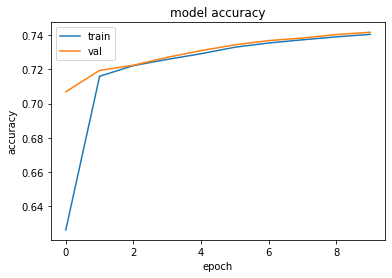

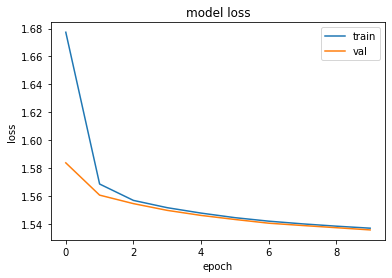

Test loss: 1.5362221417420456
Test accuracy: 0.7408500909805298


C:\Users\Milan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

       Spruce/Fir       0.72      0.77      0.75     42368
   Lodgepole Pine       0.78      0.83      0.80     56661
   Ponderosa Pine       0.60      0.91      0.72      7151
Cottonwood/Willow       0.00      0.00      0.00       549
            Aspen       0.00      0.00      0.00      1899
      Douglas-fir       0.54      0.02      0.04      3473
        Krummholz       0.00      0.00      0.00      4102

         accuracy                           0.74    116203
        macro avg       0.38      0.36      0.33    116203
     weighted avg       0.70      0.74      0.71    116203



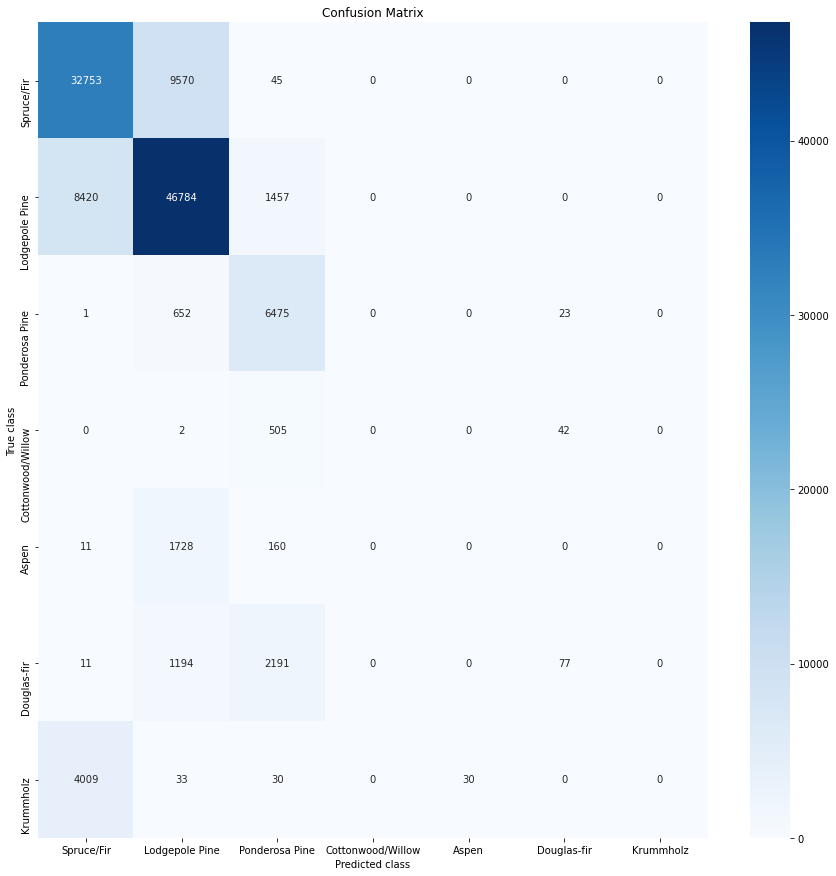

In [8]:
if __name__ == '__main__':
    main(units1=32, learning_rate=0.009, epochs=10, batch_size=1024)